Next, we shall implement the SABR model. The implied Black volatility of the SABR model is given by
  \begin{equation*}
    \begin{split}
      &\sigma_{\mbox{\tiny SABR}}(F_0, K, \alpha, \beta, \rho, \nu) \\
      &= \frac{\alpha}{(F_0K)^{(1-\beta)/2}\left\{ 1 + \frac{(1-\beta)^2}{24}\log^2\left(\frac{F_0}{K}\right) + \frac{(1-\beta)^4}{1920}\log^4\left(\frac{F_0}{K}\right) + \cdots\right\} } \\
      &\;\;\;\times \frac{z}{x(z)} \times \left\{ 1 + \left[
          \frac{(1-\beta)^2}{24}
          \frac{\alpha^2}{(F_0K)^{1-\beta}}+\frac{1}{4}\frac{\rho\beta\nu\alpha}{(F_0K)^{(1-\beta)/2}}+\frac{2-3\rho^2}{24}\nu^2\right]
        T + \cdots \right.
    \end{split}
  \end{equation*}
  where
  \begin{equation*}
    \begin{split}
      z = \frac{\nu}{\alpha} (F_0K)^{(1-\beta)/2}
      \log\left(\frac{F_0}{K}\right),
    \end{split}
  \end{equation*}
  and
  \begin{equation*}
    \begin{split}
      x(z) = \log \left[ \frac{\sqrt{1-2\rho z+z^2}+z -\rho}{1-\rho}
      \right].
    \end{split}
  \end{equation*}

This can be implemented in Python as follows:

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import norm
from scipy.optimize import brentq
from scipy import interpolate

In [9]:
###Import Data###
discount = pd.read_csv('discount.csv')
call_df = pd.read_csv('goog_call.csv',parse_dates = ['date','expiry'])
call_df['price'] = (call_df['best_bid']+call_df['best_offer'])/2

put_df = pd.read_csv('goog_put.csv',parse_dates = ['date','expiry'])
put_df['price'] = (put_df['best_bid']+put_df['best_offer'])/2

In [10]:
###Variables###
S = 846.9 #Google stock price on 30-Aug-2013
Days = 505
y_interp = interpolate.interp1d(discount.iloc[:,0], discount.iloc[:,1]/100)
r = y_interp(Days)
#r = (0.0006*Days+0.0983)/100 #equation from Excel 'discount' interpolation, note: is in %, so /100
T = Days/365 #in years
#strike_call = call_df['strike']
price_call = call_df['price']
price_put = put_df['price']
F = S*np.exp(r*T)
strikes = np.arange(320, 1370, 10)
sigma = 0.24846824068230955 #ATM: $846.90 using Bachelier Model
B=0.75 #trial & error to match model prices to actual prices

In [11]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma


To plot the implied volatility smile for the normal (Bachelier) model, just replaced the "BlackScholesCall" with the Bachelier formula.

Next, we look at the SABR model. The program "sabr.py" contains the function

\begin{equation*}
\begin{split}
\mbox{SABR}(F, K, T, \alpha, \beta, \rho, \nu)
\end{split}
\end{equation*}

The function returns a volatility $\sigma_{\mbox{SABR}}$ for the Black76Lognormal call or put option formula, so that

\begin{equation*}
\begin{split}
\mbox{Call price} &= \mbox{BlackScholesCall}(S, K, r, \sigma_{\mbox{SABR}}, T) \\
\mbox{Put price} &= \mbox{BlackScholesPut}(S, K, r, \sigma_{\mbox{SABR}}, T) \\
\end{split}
\end{equation*}

How do we determine the parameters $\alpha$, $\rho$ and $\nu$?
- We choose them so that the output of the SABR model matches the implied volatilities observed in the market.
- We refer to this process as "model calibration".

In other words, defining

  \begin{equation*}
    \begin{split}
      \sigma_{\mbox{Mkt}}(K_1) - \mbox{SABR}(F, K_1, T, \alpha, 0.5, \rho, \nu) &= \epsilon_1 \\
      \sigma_{\mbox{Mkt}}(K_2) - \mbox{SABR}(F, K_2, T, \alpha, 0.5, \rho, \nu) &= \epsilon_2 \\
      \vdots&\\
      \sigma_{\mbox{Mkt}}(K_n) - \mbox{SABR}(F, K_n, T, \alpha, 0.5, \rho, \nu) &= \epsilon_n \\
    \end{split}
  \end{equation*}

We want to minimize the sum of squared error terms as follows:
  
  \begin{equation*}
    \begin{split}
      \min_{\substack{\alpha,\; \rho,\; \nu}} \;\sum_{i=1}^n \epsilon_i^2
    \end{split}
  \end{equation*}

We use the "least_squares" algorithm in "scipy" package to calibrate the SABR model parameters:


In [15]:
from scipy.optimize import least_squares


def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], 0.5, x[1], x[2]))**2

    return err


# Here, load DataFrame with strike and implied volatility information into "df"
###

def Bachelier_VanillaCall(S,K,sigma,T):
    d1=(S-K)/(sigma*S*np.sqrt(T))
    return (S-K)*norm.cdf(d1) + sigma*S*np.sqrt(T)*norm.pdf(d1)

def impliedCallVol_Bachelier(S, K, r, price, T):
    impliedVol_Bachelier = brentq(lambda x: price -
                        Bachelier_VanillaCall(S,K,x,T),
                        -5, 5)
    return impliedVol_Bachelier

impliedvol_list = []
strike_list = []
for i in call_df.index:
    K = call_df.values[i][2]
    price = call_df.values[i][5]
    tmp = impliedCallVol_Bachelier(846.9, K, 0.26, price, T)
    impliedvol_list.append(tmp)
    strike_list.append(strike)

df = pd.concat([pd.DataFrame(strike_list),pd.DataFrame(impliedvol_list)], axis=1)
df.columns = ['strike','impliedvol']


initialGuess = [0.9907772775858795, -0.28514715188444956, 0.3522271433749251]
res = least_squares(lambda x: sabrcalibration(x,
                                              df['strike'].values,
                                              df['impliedvol'].values,
                                              F,
                                              T),
                    initialGuess)
alpha = res.x[0]
beta = 0.8
rho = res.x[1]
nu = res.x[2]
sabrsigma = SABR(F, K, T, alpha, beta, rho, nu)

print('alpha:', alpha)
print('beta:', beta)
print('rho:', rho)
print('nu:', nu)
print('SABR sigma:',sabrsigma)
print(res)

alpha: 1.0982023405241743
beta: 0.8
rho: -0.3499723778111935
nu: 0.8216073133981154
SABR sigma: 0.2999548573801888
 active_mask: array([0., 0., 0.])
        cost: 0.002570456287148351
         fun: array([0.07170016])
        grad: array([-1.78826920e-07,  8.40041768e-08, -6.41116138e-07])
         jac: array([[-2.49409382e-06,  1.17160380e-06, -8.94162804e-06]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 21
        njev: 12
  optimality: 6.411161379942215e-07
      status: 2
     success: True
           x: array([ 1.09820234, -0.34997238,  0.82160731])


In [ ]:
# ###Call Functions###
# def BlackScholesCallSABR(S, K, r, sabrsigma, T):
#     d1 = (np.log(S/K)+(r+sabrsigma**2/2)*T) / (sabrsigma*np.sqrt(T))
#     d2 = d1 - sigma*np.sqrt(T)
#     return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

# def impliedCallVolatilitySABR(S, K, r, price, T):
#     impliedVol = brentq(lambda x: price - BlackScholesCallSABR(S, K, r, x, T), 1e-6, 1)
#     return impliedVol

In [494]:
# ###Put Functions###
# def BlackScholesPutSABR(S, K, r, sabrsigma, T):
#     d1 = (np.log(S/K)+(r+sabrsigma**2/2)*T) / (sabrsigma*np.sqrt(T))
#     d2 = d1 - sigma*np.sqrt(T)
#     return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

# def impliedPutVolatilitySABR(S, K, r, price, T):
#     impliedVol = brentq(lambda x: price - BlackScholesPutSABR(S, K, r, x, T), 1e-6, 1)
#     return impliedVol

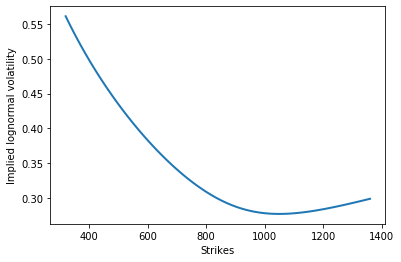

In [20]:
###SABRModel###
summarySABR = []
for K in strikes:
    impliedvol = SABR(F, K, T, alpha, beta, rho, nu)
    summarySABR.append([K, impliedvol])
    
dfSABR = pd.DataFrame(summarySABR, columns=['strike', 'vol'])
plt.plot(dfSABR['strike'], dfSABR['vol'], linewidth=2.0)
#plt.axis([310, 1380, 0, 0.4])
plt.xlabel('Strikes')
plt.ylabel('Implied lognormal volatility')
plt.show()
################

In [22]:
df

,strike,impliedvol
0,320.0,0.189748
1,320.0,0.213144
2,320.0,0.213512
3,320.0,0.218284
4,320.0,0.221423
5,320.0,0.222312
6,320.0,0.224686
7,320.0,0.227961
8,320.0,0.227826
9,320.0,0.230921
